<a href="https://colab.research.google.com/github/lszam/plates/blob/main/parana_map1234_22AGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bacia do Paraná -Superfície MAP1 MAP2 MAP3
#####Superfície
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
https://www.educative.io/answers/how-to-use-the-scipyinterpolategriddata-method

##Recuperar coordenadas x, y reais dos pontos interpretados nas seções
Salva em csv os pontos mapeados com as coordenadas reais

In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from scipy.interpolate import interp1d
import numpy as np
import os
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
from google.colab import drive

drive.mount('/content/drive')
diretorio = '/content/drive/MyDrive/Colab Notebooks/superficies'

Mounted at /content/drive


In [3]:
# Recebe SHPs. Os SHPs devem conter a coluna PROFILE,
# indicando em qual linha os pontos foram mapeados (A, B, C, etc)
filename_BASEMAP = str(diretorio +'/map_BASEMAP_17ago23.shp')
gdf_BASEMAP = gpd.read_file(filename_BASEMAP)
filename_PTS = str(diretorio +'/map_pts_map1234.shp')
gdf_PTS = gpd.read_file(filename_PTS)
gdf_PTS

,Line,X,Y,PROFILE,S,geometry
0,S1AA_pt,4.0535,-548.7343,AA,1.0,POINT (4.054 -548.734)
1,S1AA_pt,17.1264,-573.0718,AA,1.0,POINT (17.126 -573.072)
2,S1AA_pt,31.5803,-596.0203,AA,1.0,POINT (31.580 -596.020)
3,S1AA_pt,70.5921,-582.8245,AA,1.0,POINT (70.592 -582.825)
4,S1AA_pt,111.0769,-569.9466,AA,1.0,POINT (111.077 -569.947)
...,...,...,...,...,...,...
2301,S4AX_pt,1312.4480,-52.8565,AX,4.0,POINT (1312.448 -52.856)
2302,S4AY_pt,1175.0662,-53.1027,AY,4.0,POINT (1175.066 -53.103)
2303,S4AY_pt,1205.6887,-41.1251,AY,4.0,POINT (1205.689 -41.125)
2304,S4AY_pt,1222.8898,-41.6475,AY,4.0,POINT (1222.890 -41.648)


In [4]:
gdf_BASEMAP

,Line,X,Y,PROFILE,ETOPO1,long,lat,geometry
0,SA,-6505.6,-1862.1,A,0.1012,-58.441182,-16.600240,POINT (-6505.643 -1862.139)
1,SA,-6503.8,-1861.4,A,0.1021,-58.424318,-16.594264,POINT (-6503.765 -1861.449)
2,SA,-6501.9,-1860.8,A,0.1024,-58.407454,-16.588288,POINT (-6501.888 -1860.759)
3,SA,-6500.0,-1860.1,A,0.1019,-58.390591,-16.582312,POINT (-6500.011 -1860.070)
4,SA,-6498.1,-1859.4,A,0.1015,-58.373727,-16.576336,POINT (-6498.134 -1859.380)
...,...,...,...,...,...,...,...,...
37013,SAZ,-5910.9,-4021.6,AZ,-0.0296,-53.098934,-34.125050,POINT (-5910.946 -4021.635)
37014,SAZ,-5909.4,-4022.8,AZ,-0.0316,-53.084656,-34.134119,POINT (-5909.357 -4022.849)
37015,SAZ,-5907.8,-4024.1,AZ,-0.0340,-53.070378,-34.143187,POINT (-5907.767 -4024.063)
37016,SAZ,-5906.2,-4025.3,AZ,-0.0366,-53.056100,-34.152254,POINT (-5906.178 -4025.277)


In [ ]:
# Extrair as coordenadas X e Y da propriedade "geometry"
gdf_BASEMAP['X'] = gdf_BASEMAP['geometry'].apply(lambda p: p.x)
gdf_BASEMAP['Y'] = gdf_BASEMAP['geometry'].apply(lambda p: p.y)
gdf_PTS['Distance'] = gdf_PTS['geometry'].apply(lambda p: p.x)
gdf_PTS['Depth'] = gdf_PTS['geometry'].apply(lambda p: p.y)

#Separar as linhas existentes
line_name, pts_name = [], []
#Adicionar valores não repetidos
[line_name.append(item) for item in gdf_BASEMAP.PROFILE if not line_name.count(item)]
[pts_name.append(item) for item in gdf_PTS.PROFILE if not pts_name.count(item)]
#print("Linhas encontradas no MAPA BASE: ", line_name)

#----------------------------
# RECUPERAR COORDENADAS X E Y
#----------------------------

df_PTS_REAL_XY = pd.DataFrame(columns=['PROFILE', 'X', 'Y', 'Z', 'S'])

#Iterar sobre as linhas de A ate AW
for i in range(len(line_name)):

  # DISTANCIAS
  # Seleciona a linha da vez
  LINE = gdf_BASEMAP[(gdf_BASEMAP['PROFILE'] == line_name[i])]
  LINE_XY = LineString(LINE[['X', 'Y']].values)

  # Calcular a distância cumulativa entre os pontos da linha em LINE
  LINE.loc[:, 'Distance'] = LINE['X'].apply(lambda x: LINE_XY.project(Point(x, LINE.loc[LINE['X'] == x, 'Y'].iloc[0])))

  # INTERPOLADORES
  # Criar uma função interpoladora com base nos pontos da linha
  interpolador_x = interp1d(LINE['Distance'], LINE['X'], fill_value='extrapolate', kind = 'linear', assume_sorted = False)
  interpolador_y = interp1d(LINE['Distance'], LINE['Y'], fill_value='extrapolate', kind = 'linear', assume_sorted = False)

  # PONTOS MAPEADOS de cada superfície
  n_surfaces = 4 #num de superficies
  # Iterar sobre as superficies
  for s in range (1, n_surfaces+1):
    PTS_S = gdf_PTS[(gdf_PTS['PROFILE']==line_name[i]) & (gdf_PTS['S']==s)]
    PTS_S_FINAL = []
    # Iterar sobre os pontos do shapefile (superficie s)
    for j in range(len(PTS_S)):
      dist = PTS_S['Distance'].values[j] # distância relativa do ponto em relação ao início da linha
      # Obter as coordenadas X e Y interpoladas
      x_interpolado = float(interpolador_x(dist))
      y_interpolado = float(interpolador_y(dist))
      # Adicionar as coordenadas X e Y à lista
      PTS_S_FINAL.append((line_name[i], x_interpolado, y_interpolado, PTS_S['Depth'].values[j],PTS_S['S'].values[j]))

    PTS_S_FINAL = pd.DataFrame(PTS_S_FINAL, columns=['PROFILE', 'X', 'Y', 'Z', 'S'])
    df_PTS_REAL_XY = pd.concat([df_PTS_REAL_XY, PTS_S_FINAL], ignore_index=True)

df_PTS_REAL_XY = df_PTS_REAL_XY.sort_values(by=['Y', 'X'])

# Eliminar pontos "infinitos"
#(ocorreu quando ocorreu um ponto fora da linha, mas por pouco)
df_PTS_REAL_XY.replace([np.inf, -np.inf], np.nan, inplace=True)
# Retirar linhas com NaN
df_PTS_REAL_XY.dropna(inplace=True)
#Salvar saida
df_PTS_REAL_XY.to_csv('map123_python_realxy.csv')

# Separar as superfícies
df_PTS_REAL_XY_map1 = df_PTS_REAL_XY[df_PTS_REAL_XY.apply(lambda s: s['S'] == 1, axis=1)]
df_PTS_REAL_XY_map2 = df_PTS_REAL_XY[df_PTS_REAL_XY.apply(lambda s: s['S'] == 2, axis=1)]
df_PTS_REAL_XY_map3 = df_PTS_REAL_XY[df_PTS_REAL_XY.apply(lambda s: s['S'] == 3, axis=1)]
df_PTS_REAL_XY_map4 = df_PTS_REAL_XY[df_PTS_REAL_XY.apply(lambda s: s['S'] == 4, axis=1)]
#Salvar saída de pontos com coordenadas reais
df_PTS_REAL_XY_map1.to_csv('map1_python_realxy.csv')
df_PTS_REAL_XY_map2.to_csv('map2_python_realxy.csv')
df_PTS_REAL_XY_map3.to_csv('map3_python_realxy.csv')
df_PTS_REAL_XY_map4.to_csv('map4_python_realxy.csv')

In [6]:
df_PTS_REAL_XY

,PROFILE,X,Y,Z,S
2295,AX,-6015.029272,-3813.168105,-52.856451,4.0
2305,AY,-6100.096949,-3813.038331,-53.136607,4.0
1159,AW,-5934.723610,-3811.548648,-52.724893,4.0
2294,AX,-6022.023296,-3807.825730,-43.933106,4.0
2304,AY,-6115.997103,-3800.904003,-41.647539,4.0
...,...,...,...,...,...
8,A,-5847.021473,-1620.101763,-150.880521,2.0
1195,C,-5578.429112,-1617.903678,-39.618214,2.0
1239,D,-5450.278720,-1617.544421,-41.828236,2.0
9,A,-5820.512573,-1610.359976,-159.009649,2.0


##Interpolação para grade regular e azimute da superfície

In [56]:
#Parametros
n_surfaces = 4
cell = 50
s_lista = [1,2,4,3] # Ss fora de ordem numérica para facilitar a plotagem
paleta = ['Reds_r', 'Greens_r', 'Blues_r', 'Purples_r']
gdf_basin = gpd.read_file('bacia_limite_ln.shp')

azim = []
S_sizes = []
S_interp = pd.DataFrame()

for i in s_lista:
  # Definir a grade regular para o mapa interpolado
  X = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i]['X'].values
  Y = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i]['Y'].values
  Z = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i]['Z'].values
  nx_divisions = round((np.max(X)-np.min(X))/cell)
  ny_divisions = round((np.max(Y)-np.min(Y))/cell)
  xi = np.linspace(min(X), max(X), nx_divisions)
  yi = np.linspace(min(Y), max(Y), ny_divisions)
  xi, yi = np.meshgrid(xi, yi)
  # Interpolar os valores Z na grade regular
  zi = griddata((X, Y), Z, (xi, yi), method='linear')
  # Salvar superficie em csv
  data_surface = pd.DataFrame({'X': np.ndarray.flatten(xi),
                               'Y': np.ndarray.flatten(yi),
                               'Z': np.ndarray.flatten(zi),
                               'S': i})
  data_name = "python_interp_s"+str(i)+".csv"
  data_surface.to_csv(data_name)

  data_surface = pd.DataFrame({'X': [xi], 'Y': [yi], 'Z': [zi], 'S': i})
  S_interp = pd.concat([S_interp, data_surface]) #guardar os meshs
  S_sizes.append([np.shape(zi), i]) #guardar os tamanhos


In [57]:
S_interp[S_interp['S']==1]['X'].values[0]

array([[-6963.38747847, -6911.29135775, -6859.19523703, ...,
        -5244.21549467, -5192.11937395, -5140.02325322],
       [-6963.38747847, -6911.29135775, -6859.19523703, ...,
        -5244.21549467, -5192.11937395, -5140.02325322],
       [-6963.38747847, -6911.29135775, -6859.19523703, ...,
        -5244.21549467, -5192.11937395, -5140.02325322],
       ...,
       [-6963.38747847, -6911.29135775, -6859.19523703, ...,
        -5244.21549467, -5192.11937395, -5140.02325322],
       [-6963.38747847, -6911.29135775, -6859.19523703, ...,
        -5244.21549467, -5192.11937395, -5140.02325322],
       [-6963.38747847, -6911.29135775, -6859.19523703, ...,
        -5244.21549467, -5192.11937395, -5140.02325322]])

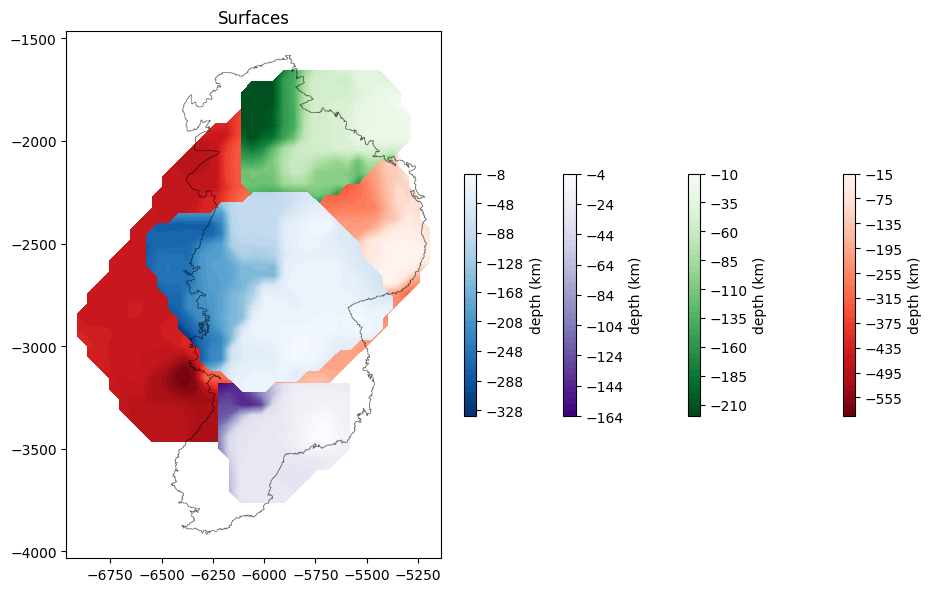

In [102]:
import math

plt.figure(figsize=(10,10))

for i in s_lista:
  #Obter o azimute
  xi = S_interp[S_interp['S']==i]['X'].values[0] #[0] para puxar o array do array...
  yi = S_interp[S_interp['S']==i]['Y'].values[0]
  zi = S_interp[S_interp['S']==i]['Z'].values[0]
  grad_x, grad_y = np.gradient(zi) #gradiente da superfície
  grad_x = np.nan_to_num(grad_x, nan=0) # Substituir NaN por 0
  grad_y = np.nan_to_num(grad_y, nan=0) # Substituir NaN por 0
  azim_med = np.degrees(np.arctan2(np.mean(grad_x), np.mean(grad_y))) #azimute médio
  real_azim = abs(azim_med - 270) #azimute real em relação ao norte geográfico
  azim.append((i, real_azim))
  #print("\n   Real azimuth of surface %d: %d" % (i, real_azim))
  zi_temp = np.nan_to_num(zi, nan=0)
  #levels = list(range(int(np.min(zi_temp)), int(np.max(zi_temp)), 20))
  #levels = list(range((math.ceil(np.min(zi_temp)/100)*100),
                      #(math.ceil(np.max(zi_temp)/100)*100 + 10),
                      #10))
  #levels = list(range((math.ceil(np.min(zi_temp)/100)*100) - 100, 0, 10))
  #levels = list(range(int(np.min(zi_temp)), 0, 10))
  levels = 50
  plt.contourf(xi, yi, zi, levels=levels,
               cmap=paleta[i-1])
  cbar = plt.colorbar(shrink=0.25)
  cbar.set_label('depth (km)', fontsize=10)
  #cbar.set_ticks([])  # Remover os ticks da barra de cores

#Contorno da bacia
gdf_basin.plot(ax=plt.gca(), facecolor='none', alpha = 0.6,
                edgecolor='black', linewidth = 0.5)

plt.title('Surfaces')
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.savefig('py_surfaces_map_v1', dpi=300)
plt.show()

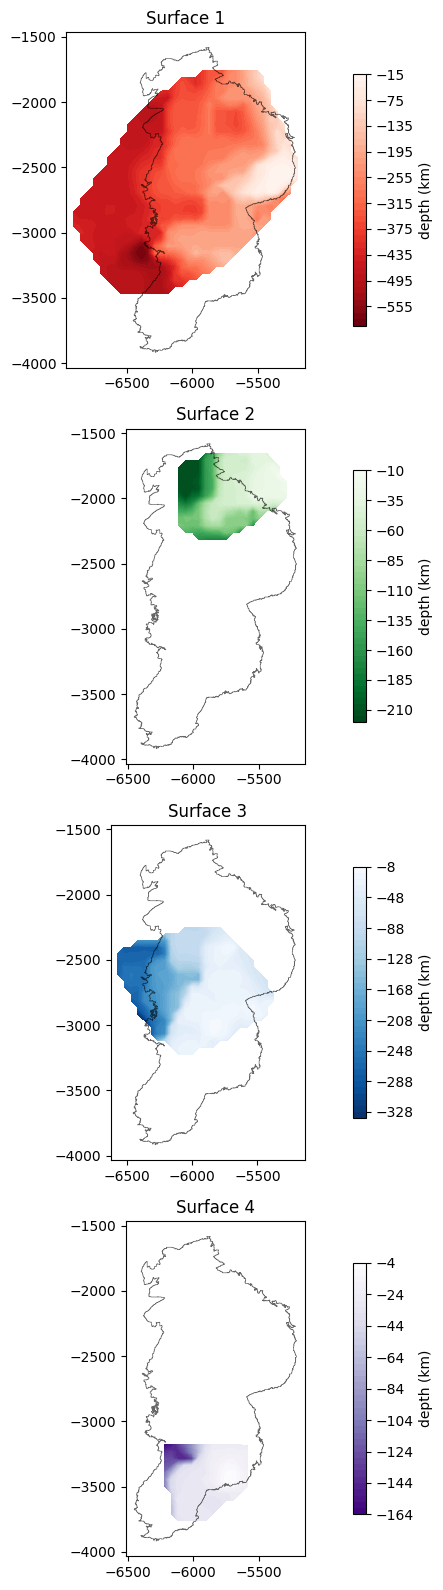

In [99]:
import math

# Crie uma figura com subplots
fig, axes = plt.subplots(len(s_lista), 1, figsize=(10, 4 * len(s_lista)))

for i in s_lista:
    ax = axes[i-1]
    xi = S_interp[S_interp['S'] == i]['X'].values[0]
    yi = S_interp[S_interp['S'] == i]['Y'].values[0]
    zi = S_interp[S_interp['S'] == i]['Z'].values[0]
    zi_temp = np.nan_to_num(zi, nan=0)
    levels = 50  # Defina os níveis de contorno desejados
    contour = ax.contourf(xi, yi, zi, levels=levels, cmap=paleta[i - 1])
    cbar = fig.colorbar(contour, ax=ax, shrink=0.75)
    cbar.set_label('depth (km)', fontsize=10)

    gdf_basin.plot(ax=ax, facecolor='none', alpha=0.6, edgecolor='black', linewidth=0.5)

    ax.set_title(f'Surface {i}')
    ax.set_aspect("equal")

# Ajuste os subplots para garantir que não haja sobreposição
plt.tight_layout()

# Salve a figura
plt.savefig('py_surfaces_map_v2', dpi=300)

# Mostre a figura
plt.show()


Azimutes

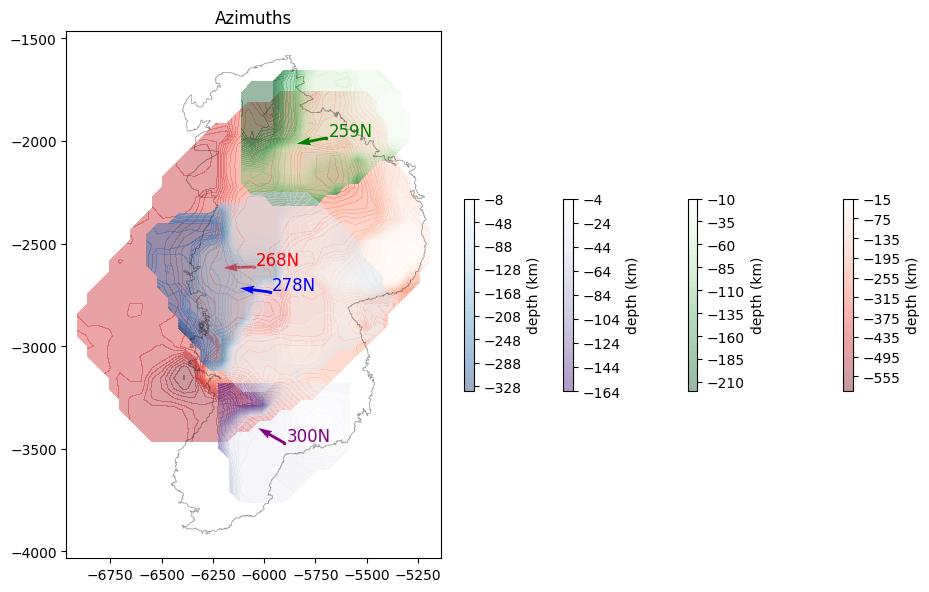

In [103]:
import math

cor = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(10,8))

for i in s_lista:
  xi = S_interp[S_interp['S']==i]['X'].values[0] #[0] para puxar o array do array...
  yi = S_interp[S_interp['S']==i]['Y'].values[0]
  zi = S_interp[S_interp['S']==i]['Z'].values[0]
  #Obter o azimute
  grad_x, grad_y = np.gradient(zi) #gradiente da superfície
  grad_x = np.nan_to_num(grad_x, nan=0) # Substituir NaN por 0
  grad_y = np.nan_to_num(grad_y, nan=0) # Substituir NaN por 0
  azim_med = np.degrees(np.arctan2(np.mean(grad_x), np.mean(grad_y))) #azimute médio
  real_azim = abs(azim_med - 270) #azimute real em relação ao norte geográfico
  azim.append((i, real_azim))
  #print("\n   Real azimuth of surface %d: %d" % (i, real_azim))
  zi_temp = np.nan_to_num(zi, nan=0)
  levels=50
  plt.contourf(xi, yi, zi, levels=levels, cmap=paleta[i-1], alpha=0.4)
  #cbar = plt.colorbar(shrink=0.75)
  cbar = plt.colorbar(shrink=0.25)
  cbar.set_label('depth (km)', fontsize=10)

  arrow_length = 0.08
  arrow_start_x = np.mean(xi)
  arrow_start_y = np.mean(yi)
  label = str(round(real_azim)) +'N'
  plt.scatter(arrow_start_x,arrow_start_y, s=2, color=cor[i-1])
  plt.text(arrow_start_x+10,arrow_start_y+10, label, color=cor[i-1], size=12)
  plt.quiver(arrow_start_x, arrow_start_y,
             arrow_length * np.cos(np.radians(azim_med+180)),
             arrow_length * np.sin(np.radians(azim_med+180)),
             color = cor[i-1], scale=1)

#Contorno da bacia
gdf_basin.plot(ax=plt.gca(), facecolor='none', alpha = 0.4,
                edgecolor='black', linewidth = 0.5)

plt.title('Azimuths')
plt.gca().set_aspect("equal")
plt.savefig('py_surfaces_azimuth', dpi=300)
plt.tight_layout()
plt.show()




##Outros mapas

NameError: ignored

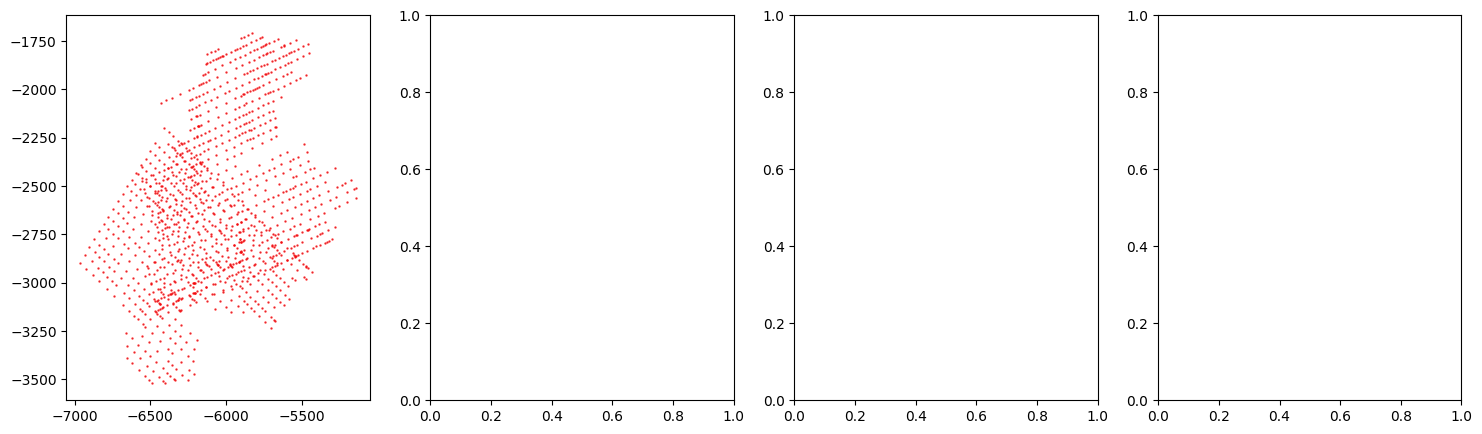

In [62]:
# Criar subplots
cor = ['red', 'green', 'blue', 'purple']
fig, axs = plt.subplots(1, len(s_lista), figsize=(18, 5))
for i in range(len(s_lista)):
  X = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i+1]['X'].values
  Y = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i+1]['Y'].values
  ax = axs[i].scatter(X, Y, s=0.5, edgecolor=cor[i], alpha=0.8)

  Z = df_PTS_REAL_XY[df_PTS_REAL_XY['S']==i+1]['Z'].values

  plt.contourf(zgrid, levels=levels, cmap=paleta[i-1], alpha=0.2)
  plt.gca().set_aspect("equal")
  plt.tight_layout()
  #gdf_basin.plot(ax=ax, color='none', edgecolor='black')

#plt.xlabel('Easting')
#plt.ylabel('Northing')
#plt.title('Map locations')


##3D interativos

In [135]:
# --------------------------------------
# Interpolar, gerar 3D interativo e HTML
# --------------------------------------
import plotly.graph_objects as go

paleta = ['Reds_r', 'Greens_r', 'Blues_r', 'Purples_r']

fig = go.Figure()
for i in s_lista:
    xi = S_interp[S_interp['S'] == i]['X'].values[0] #[0] para puxar o array do array...
    yi = S_interp[S_interp['S'] == i]['Y'].values[0]
    zi = S_interp[S_interp['S'] == i]['Z'].values[0]
    fig.add_trace(go.Surface(z=zi, x=xi, y=yi, colorscale=paleta[i-1],
                             name='Surface ' + str(i),
                             colorbar=dict(len=0.5,  x=((s_lista[i-1])*0.06)+0.8)))
fig.update_layout(scene=dict(xaxis_title='Easting', yaxis_title='Northing', zaxis_title='Depth'))

# Salve a figura como um arquivo HTML temporário
html_path = "plotly_surfaces.html"
fig.write_html(html_path)
print(f"Figura salva como HTML: {html_path}")

fig.show()


Figura salva como HTML: plotly_surfaces.html


In [180]:
# Add surface trace

import plotly.graph_objects as go
from plotly.subplots import make_subplots


paleta = ['Reds_r', 'Greens_r', 'Blues_r', 'Purples_r']

fig = go.Figure()
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': False}, {'is_3d': True}]],
                    subplot_titles=['Map', 'Surfaces'],
                    )
for i in s_lista:
    xi = S_interp[S_interp['S'] == i]['X'].values[0] #[0] para puxar o array do array...
    yi = S_interp[S_interp['S'] == i]['Y'].values[0]
    zi = S_interp[S_interp['S'] == i]['Z'].values[0]
    fig.add_trace(go.Surface(z=zi, x=xi, y=yi, colorscale=paleta[i-1],
                             name='Surface ' + str(i),
                             colorbar=dict(title='S'+str(i), len=0.3,  x=((s_lista[i-1])*0.05)+0.8)), 1, 2)

'''
#Criar Plano ZERO
X = df_PTS_REAL_XY['X'].values
Y = df_PTS_REAL_XY['Y'].values
Z = df_PTS_REAL_XY['Z'].values*0
Z = np.nan_to_num(Z, nan=0)
nx_divisions = round((np.max(X)-np.min(X))/cell)
ny_divisions = round((np.max(Y)-np.min(Y))/cell)
x0 = np.linspace(min(X), max(X), nx_divisions)
y0 = np.linspace(min(Y), max(Y), ny_divisions)
x0, y0 = np.meshgrid(x0, y0)
z0 = griddata((X, Y), Z, (x0, y0), method='linear')
fig.add_trace(go.Surface(z=z0, x=x0, y=y0 , colorscale='Greys', name='Surface ' + str(i)), 1, 2)
'''

fig.update_layout(scene=dict(xaxis_title='Easting', yaxis_title='Northing', zaxis_title='Depth'), scene_camera_eye=dict(x=-2, y=-2, z=2.5))

# Salve a figura como um arquivo HTML temporário
html_path = "plotly_surfaces_v2.html"
fig.write_html(html_path)
print(f"Figura salva como HTML: {html_path}")

fig.show()


Figura salva como HTML: plotly_surfaces_v2.html


In [144]:
Z2